# Full Implementation of Neural Network

#### Import Libraries

In [16]:
import scipy.io
import numpy as np
from scipy.optimize import fmin_cg
import pickle

#### Load weights to verify cost function

In [4]:
mat = scipy.io.loadmat('ex4weights.mat')

#### Retrieving parameters for the input and hidden layers

In [5]:
Theta1 = mat['Theta1']
Theta2 = mat['Theta2']

### Loading the DataSet

In [6]:
data = scipy.io.loadmat('ex4data1.mat')

#### Getting X and y matrices

In [75]:
X = data['X']
y = data['y']

# Shuffle them in random order (only rows)
# to make model more flexible

np.random.shuffle(X)
np.random.shuffle(y)

### Splitting the dataset to train_set and test_set

In [101]:
m_train = 4900
m_test = 100

X_train = X[0:4900]
y_train = y[0:4900]

X_test = X[4900:]
y_test = y[4900:]

### Unroll parameters

In [7]:
print(np.shape(Theta1), 25*401)
print(np.shape(Theta2), 10*26)

(25, 401) 10025
(10, 26) 260


In [8]:
nn_params = np.concatenate([Theta1.flatten(), Theta2.flatten()])
np.shape(nn_params)

(10285,)

### Rollback

In [9]:
Theta1 = np.reshape(nn_params[0:10025], (-1, 401))
Theta2 = np.reshape(nn_params[10025:10285], (-1, 26))

#### Setup some useful variables

In [356]:
m = np.shape(X)[0] # number of  examples
n = np.shape(X)[1] # number of features
k = 10 # number of labels
J = 0 # Cost function value

400

## Implementing the cost function

#### Converting y( y(i) -> 1:10) to Y( Y(i) -> 0, 1)

In [11]:
# Y = matrix of where each row(i) 
# represents corresponding X(i) example
# and each column correlates to output's classes
y[y == 0] = 10

Y = np.zeros([m, k])
for i in range(m):
    j = y[i]
    Y[i, j-1] = 1

#### Implementing sigmoid function

In [24]:
def sigmoid(z):
    #return 1.0 / (1.0 + np.exp(-z))
    return np.divide(1.0, (np.add(1.0, np.exp(np.negative(z)))))

## Implementing Forward Propagation

In [49]:
#predictions = sigmoid(np.ones([m, 1]), sigmoid([np.ones([])]))

# Added bias feature to the input layer
a1 = np.concatenate([np.ones([m, 1]), X], axis=1)

# Activation of the hidden layer
z2 = sigmoid(np.matmul(a1, np.transpose(Theta1)))
      
# Added bias feature to the hidden layer
a2 = np.concatenate([np.ones([m, 1]), z2], axis=1)

# Activation of the output layer
z3 = sigmoid(np.matmul(a2, np.transpose(Theta2)))

# The cost function value:
logErrors = np.multiply(Y, np.log(z3)) + np.multiply(np.subtract(1, Y), np.log(np.subtract(1, z3)))
J = -1/m * np.sum(logErrors)

print(f"The cost value without regularization is {J}")

NameError: name 'Y' is not defined

### Adding the Regularization term

In [48]:
# Choosing the lambda value
lmda = 0.1

# The reg term
reg = lmda/(2*m) * (np.sum((Theta1[:, 1:]**2)) + np.sum((Theta2[:, 1:]**2)))

J = -1/m * np.sum(logErrors) + reg
print(f"The cost value with regularization is {J}")

NameError: name 'logErrors' is not defined

### Implementing the sigmoidGradient function

In [10]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z), np.subtract(1, sigmoid(z)))

### Randomly initialize the parameters for symmetry breaking

In [11]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = np.sqrt(6)/(np.sqrt(L_in + L_out))
    return np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

## Backward Propagation

In [82]:
# Added bias feature to the input layer
a1 = np.concatenate([np.ones([m, 1]), X], axis=1)

# Matrix Product of a1 and Theta1
z2 = np.matmul(a1, np.transpose(Theta1))

# Activation of the hidden layer
a2 = np.concatenate([np.ones([m, 1]), sigmoid(z2)], axis=1)

# Matrix Product of a2 and Theta2
z3 = np.matmul(a2, np.transpose(Theta2))

# Activation of the output layer
a3 = sigmoid(z3)

# Error of the output layer
d3 = np.subtract(a3, Y)

# Error of the hidden layer
d2 = np.multiply(np.matmul(d3, Theta2[:, 1:]), sigmoidGradient(z2))

# Accumulate the gradient, vectorized version
Delta1 = np.matmul(np.transpose(d2), a1)
Delta2 = np.matmul(np.transpose(d3), a2)

# Obtain the gradient by dividing the accumulated gradients by m
Theta1_grad = np.divide(Delta1, m)
Theta2_grad = np.divide(Delta2, m)

# Add regularization to the gradient
Theta1_grad[:, 2:] = Theta1_grad[:, 2:] + lmda/m*Theta1_grad[:, 2:]
Theta2_grad[:, 2:] = Theta2_grad[:, 2:] + lmda/m*Theta2_grad[:, 2:]

# Unrolling out gradient parameters
grad = np.concatenate([Theta1_grad.flatten(), Theta2_grad.flatten()])

(10285,)

## Function to find the cost value for scipy.optimize

In [49]:
def costFunction(nn_params, X, y, lmda):
    
    X = np.reshape(X, (-1, 400))
    
    Theta1 = np.reshape(nn_params[0:10025], (-1, 401))
    Theta2 = np.reshape(nn_params[10025:10285], (-1, 26))
    
    m = np.shape(X)[0]
    y[y == 0] = 10
    Y = np.zeros([m, k])
    for i in range(m):
        j = y[i]
        Y[i, j-1] = 1

    a1 = np.concatenate([np.ones([m, 1]), X], axis=1)

    z2 = np.matmul(a1, np.transpose(Theta1))

    a2 = np.concatenate([np.ones([m, 1]), sigmoid(z2)], axis=1)

    z3 = np.matmul(a2, np.transpose(Theta2))

    a3 = sigmoid(z3)
    
    logErrors = np.multiply(Y, np.log(a3)) + np.multiply(np.subtract(1, Y), np.log(np.subtract(1, a3)))

    reg = lmda/(2*m) * (np.sum((Theta1[:, 1:]**2)) + np.sum((Theta2[:, 1:]**2)))

    return -1/m * np.sum(logErrors) + reg

## Function to find the grad for scipy.optimize

In [48]:
def backPropagate(nn_params, X, y, lmda):
    
    X = np.reshape(X, (-1, 400))
    
    Theta1 = np.reshape(nn_params[0:10025], (-1, 401))
    Theta2 = np.reshape(nn_params[10025:10285], (-1, 26))
    
    m = np.shape(X)[0]
    y[y == 0] = 10
    Y = np.zeros([m, k])
    for i in range(m):
        j = y[i]
        Y[i, j-1] = 1
        
    a1 = np.concatenate([np.ones([m, 1]), X], axis=1)

    z2 = np.matmul(a1, np.transpose(Theta1))

    a2 = np.concatenate([np.ones([m, 1]), sigmoid(z2)], axis=1)

    z3 = np.matmul(a2, np.transpose(Theta2))

    a3 = sigmoid(z3)

    d3 = np.subtract(a3, Y)

    d2 = np.multiply(np.matmul(d3, Theta2[:, 1:]), sigmoidGradient(z2))

    Delta1 = np.matmul(np.transpose(d2), a1)
    Delta2 = np.matmul(np.transpose(d3), a2)

    Theta1_grad = np.divide(Delta1, m)
    Theta2_grad = np.divide(Delta2, m)

    Theta1_grad[:, 2:] = Theta1_grad[:, 2:] + lmda/m*Theta1_grad[:, 2:]
    Theta2_grad[:, 2:] = Theta2_grad[:, 2:] + lmda/m*Theta2_grad[:, 2:]

    return np.concatenate([Theta1_grad.flatten(), Theta2_grad.flatten()])

# scipy.optimize, fmin_cg

### fmin_cg takes my cost_function, gradient_function, params and tries to optimize the cost value by iterating the gradient_function

In [316]:
def fmin_cg_train(X_param, y_param, lmda):
    randomThetas_unrolled = np.concatenate([randInitializeWeights(400, 25).flatten(), randInitializeWeights(25, 10).flatten()])
    return fmin_cg(costFunction, fprime=backPropagate, x0=randomThetas_unrolled, args=(X_param.flatten(), y_param.flatten(), lmda), maxiter=400, disp=True, full_output=True )

## Creating a Model

In [121]:
learned_Thetas = fmin_cg_train()

         Current function value: 1.915908
         Iterations: 1600
         Function evaluations: 2622
         Gradient evaluations: 2622


## Saving the model

In [119]:
with open('./nn_model.pkl', 'wb') as f:
    pickle.dump(learned_Thetas, f)

### Load the model

In [134]:
with open('./nn_model.pkl', 'rb') as f:
    loaded_Thetas = pickle.load(f)[0]

## Predict

In [25]:
# Shaping Thetas
Theta1 = np.reshape(loaded_Thetas[0:10025], (-1, 401))
Theta2 = np.reshape(loaded_Thetas[10025:10285], (-1, 26))

# Making a prediction
a1 = np.concatenate([np.ones([m, 1]), X], axis=1)
z2 = np.matmul(a1, np.transpose(Theta1))
a2 = np.concatenate([np.ones([m, 1]), sigmoid(z2)], axis=1)
z3 = np.matmul(a2, np.transpose(Theta2))
a3 = sigmoid(z3)

# Finding the indeces of the max value in each row
predicted_values = np.argmax(a3, axis=1)

### Implementation of Prediction function

In [53]:
def nn_predict(learned_Thetas, X):
    Theta1 = np.reshape(learned_Thetas[0:10025], (-1, 401))
    Theta2 = np.reshape(learned_Thetas[10025:10285], (-1, 26))

    m = np.shape(X)[0]
    
    a1 = np.concatenate([np.ones([m, 1]), X], axis=1)
    z2 = np.matmul(a1, np.transpose(Theta1))
    a2 = np.concatenate([np.ones([m, 1]), sigmoid(z2)], axis=1)
    z3 = np.matmul(a2, np.transpose(Theta2))
    a3 = sigmoid(z3)

    return np.add(np.argmax(a3, axis=1), 1)

## Evaluating our model on the test_set

In [359]:
# Making predictions
predictions = nn_predict(loaded_Thetas, X_train)

# Compare them to actual labels and get the accuracy
print(np.mean((predictions == y_train.flatten()) * 100))

9.571428571428571


### Function that returns Accuracy

In [357]:
def accuracy(learned_Thetas, X_test, y_test):
    predictions = nn_predict(learned_Thetas, X_test)
    return np.mean((predictions == y_test.flatten()) * 100)

### Comparison of our model to a simple randomizer

In [358]:
print(accuracy(loaded_Thetas, X_train, y_train))

np.mean((1+np.random.randint(10, size=100) == y_test.flatten()) * 100)

TypeError: 'numpy.ndarray' object is not callable

### Splitting of the dataset to train, cross-validation and test sets

In [208]:
costFunction(loaded_Thetas, X_train, y_train, 0)

errors = []
lmdas = np.array([0, 0.01, 0.03, 0.1, 0.3, 1, 3])

X_all = data['X']
y_all = data['y']

np.random.shuffle(X_all)
np.random.shuffle(y_all)

X_training = X_all[0:3000]
y_training = y_all[0:3000]

X_val = X_all[3000:4000]
y_val = y_all[3000:4000]    

X_testing = X_all[4000:5000]
y_testing = y_all[4000:5000]

#errors.append(fmin_cg_train(1)[0])

print(lmdas)
print(errors)

[0.   0.01 0.03 0.1  0.3  1.   3.  ]
[]


## Diagnosing Bias vs. Variance

In [209]:
for i in lmdas:
    errors.append(fmin_cg_train(i))
    #print(i)

         Current function value: 1.875249
         Iterations: 400
         Function evaluations: 602
         Gradient evaluations: 602
         Current function value: 1.921931
         Iterations: 400
         Function evaluations: 615
         Gradient evaluations: 615
         Current function value: 1.751357
         Iterations: 400
         Function evaluations: 651
         Gradient evaluations: 651
         Current function value: 1.833712
         Iterations: 400
         Function evaluations: 690
         Gradient evaluations: 690
         Current function value: 2.201384
         Iterations: 349
         Function evaluations: 783
         Gradient evaluations: 771
         Current function value: 2.951115
         Iterations: 86
         Function evaluations: 254
         Gradient evaluations: 242
         Current function value: 3.182059
         Iterations: 30
         Function evaluations: 124
         Gradient evaluations: 112


In [211]:
cross_val = []
for i in range(7):
    cross_val.append(costFunction(errors[i][0], X_val, y_val, lmdas[i]))

for i in range(7):
    print(cross_val[i], lmdas[i])

5.105095736911198 0.0
5.063789375653575 0.01
5.982514795511465 0.03
6.118742227972356 0.1
5.683890183072789 0.3
3.8745296039961206 1.0
3.621987964795333 3.0


In [210]:
train_err = []
for i in range(7):
    train_err.append(costFunction(errors[i][0], X_training, y_training, lmdas[i]))
    
for i in range(7):
    print(train_err[i], lmdas[i])    

1.8752494765075418 0.0
1.9219308181490176 0.01
1.7513571347374786 0.03
1.8337118263486882 0.1
2.201383652542189 0.3
2.951115208780842 1.0
3.1820587157122184 3.0


In [327]:
print(accuracy(errors[6][0], X_testing, y_testing))

10.0


In [205]:
test_val = []
for i in range(7):
    test_val.append(costFunction(errors[i][0], X_testing, y_testing, lmdas[i]))
for i in range(7):
    print(test_val[i], lmdas[i])

7.841316368834195 0.0
7.817693931158653 0.01
8.18578692998393 0.03
7.448765449565347 0.1
5.399415586111235 0.3
3.822031741043098 1.0
3.42672451322443 3.0


## Bias/Variance as a function of the regularization parameter Lambda

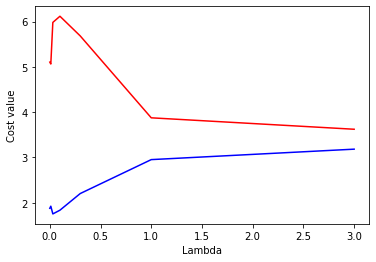

In [247]:
import matplotlib.pyplot as plt

plt.plot(lmdas,train_err,'b',label='J train')
plt.plot(lmdas, cross_val, 'r', label='J cv')

plt.xlabel('Lambda')
plt.ylabel('Cost value')

plt.show()

## Learning Curve

### Get splitted dataset
### Loop over randomly chosen k examples

#### Inner loop in range(50) to find average cost value for k examples

#### Get training and cross_val sets

In [296]:
X = data['X']
y = data['y']

# Shuffle them in random order (only rows)
# to make model more flexible

np.random.shuffle(X)
np.random.shuffle(y)

X_train_curve = X[0:2050]
y_train_curve = y[0:2050]

X_cross_curve = X[2050:4050]
y_cross_curve = y[2050:4050]

### We are taking set of 50, then 450, then 850 ... to 2050 and for each of them finding the average Cost value of 5 iterations
### After that we can plot the Learning Curve

In [350]:
# Get the vector of sum for 50 iterations for each set of m

# We store avg J_train here
sum_of_error_train = np.zeros(6)

# We store avg J_cv here
sum_of_error_val = np.zeros(6)

p = 0
for i in range(50, 2051, 400):
    print(i, p)
    for j in range(10):
        rand_IDX = np.random.permutation(2000)
        X_train_curve = X_train_curve[rand_IDX]
        y_train_curve = y_train_curve[rand_IDX]
        result_train = fmin_cg_train(X_train_curve[0:i], y_train_curve[0:i], 0.01)
        result_val = costFunction(result_train[0], X_cross_curve[0:i], y_cross_curve[0:i], 0.01)
        print(result_val)
        sum_of_error_train[p] = sum_of_error_train[p] + result_train[1]
        sum_of_error_val[p] = sum_of_error_val[p] + result_val
    
    p = p + 1
    
sum_of_error_train = sum_of_error_train/10
sum_of_error_val = sum_of_error_val/10

50 0
         Current function value: 0.254668
         Iterations: 25
         Function evaluations: 125
         Gradient evaluations: 114
9.685934286365216
         Current function value: 0.171567
         Iterations: 33
         Function evaluations: 122
         Gradient evaluations: 110
9.253449262710735
         Current function value: 0.235079
         Iterations: 21
         Function evaluations: 109
         Gradient evaluations: 98
9.780923138512566
         Current function value: 0.168043
         Iterations: 19
         Function evaluations: 98
         Gradient evaluations: 87
9.784085278510698
         Current function value: 0.168766
         Iterations: 30
         Function evaluations: 114
         Gradient evaluations: 103
10.370373964408794
         Current function value: 0.172143
         Iterations: 45
         Function evaluations: 153
         Gradient evaluations: 141
8.955170864261408
         Current function value: 0.419927
         Iterations: 23
       

[ 9.97524986 12.22627597 13.71526778 10.82305567  8.17640217  7.00553167]


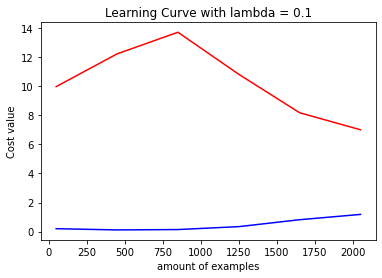

In [354]:
examples = [50, 450, 850, 1250, 1650, 2050]

print(sum_of_error_val)

plt.plot(examples, sum_of_error_train,'b',label='J train')
plt.plot(examples, sum_of_error_val, 'r', label='J cv')

plt.xlabel('amount of examples')
plt.ylabel('Cost value')
plt.title('Learning Curve with lambda = 0.1')

plt.show()

### LC with lambda = 1

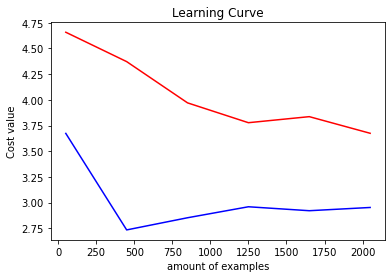

In [342]:
examples = [50, 450, 850, 1250, 1650, 2050]

plt.plot(examples, sum_of_error_train,'b',label='J train')
plt.plot(examples, sum_of_error_val, 'r', label='J cv')

plt.xlabel('amount of examples')
plt.ylabel('Cost value')
plt.title('Learning Curve')

plt.show()

### LC with lambda = 0

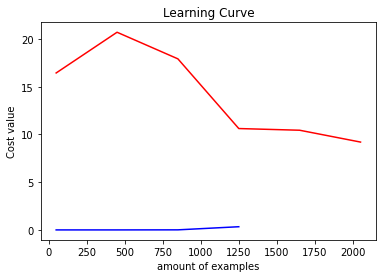

In [344]:
examples = [50, 450, 850, 1250, 1650, 2050]

plt.plot(examples, sum_of_error_train,'b',label='J train')
plt.plot(examples, sum_of_error_val, 'r', label='J cv')

plt.xlabel('amount of examples')
plt.ylabel('Cost value')
plt.title('Learning Curve')

plt.show()

### LC with lambda = 0.1

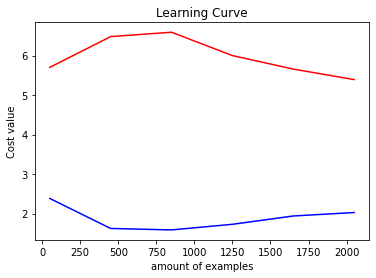

In [346]:
examples = [50, 450, 850, 1250, 1650, 2050]

plt.plot(examples, sum_of_error_train,'b',label='J train')
plt.plot(examples, sum_of_error_val, 'r', label='J cv')

plt.xlabel('amount of examples')
plt.ylabel('Cost value')
plt.title('Learning Curve')

plt.show()

# I am working on accuracy :(